In [189]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
df = pd.read_csv('ebay.csv', encoding='utf-8')
df.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


По бидам в аукционах необходимо отличить нормальное поведение(класс 0) от неадекватного(класс 1).

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 13 columns):
Record_ID                 6321 non-null int64
Auction_ID                6321 non-null int64
Bidder_ID                 6321 non-null object
Bidder_Tendency           6321 non-null float64
Bidding_Ratio             6321 non-null float64
Successive_Outbidding     6321 non-null float64
Last_Bidding              6321 non-null float64
Auction_Bids              6321 non-null float64
Starting_Price_Average    6321 non-null float64
Early_Bidding             6321 non-null float64
Winning_Ratio             6321 non-null float64
Auction_Duration          6321 non-null int64
Class                     6321 non-null int64
dtypes: float64(8), int64(4), object(1)
memory usage: 642.1+ KB


In [218]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [213]:
#y = df['Class']
#X = df.drop('Class', axis=1)

Приведём к категориальным признакам те, у которых мало уникальных значений.

In [192]:
cat_features = [cols for cols in X.columns if X[cols].nunique() <= 7]
cat_features

['Successive_Outbidding', 'Auction_Duration']

Закодируем Successive_Outbidding по Auction_Bids и Auction_Duration по Winning_Ratio.

In [219]:
m = X.groupby(['Successive_Outbidding', 'Auction_Duration'])[['Auction_Bids','Winning_Ratio']].apply(np.median)
m.name = 'MEDIAN'
X.join(m, on=['Successive_Outbidding', 'Auction_Duration'])

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,MEDIAN
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0.0000
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0.0000
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0.0000
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0.0000
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6316,15129,760,l***t,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3,0.6125
6317,15137,2481,s***s,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7,0.0000
6318,15138,2481,h***t,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7,0.0000
6319,15139,2481,d***d,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7,0.0000


In [220]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 12 columns):
Record_ID                 6321 non-null int64
Auction_ID                6321 non-null int64
Bidder_ID                 6321 non-null object
Bidder_Tendency           6321 non-null float64
Bidding_Ratio             6321 non-null float64
Successive_Outbidding     6321 non-null float64
Last_Bidding              6321 non-null float64
Auction_Bids              6321 non-null float64
Starting_Price_Average    6321 non-null float64
Early_Bidding             6321 non-null float64
Winning_Ratio             6321 non-null float64
Auction_Duration          6321 non-null int64
dtypes: float64(8), int64(3), object(1)
memory usage: 592.7+ KB


Удалим айдишники.

In [221]:
X.drop(['Record_ID', 'Auction_ID', 'Bidder_ID'], axis=1, inplace=True)

Проверим ещё распределения.

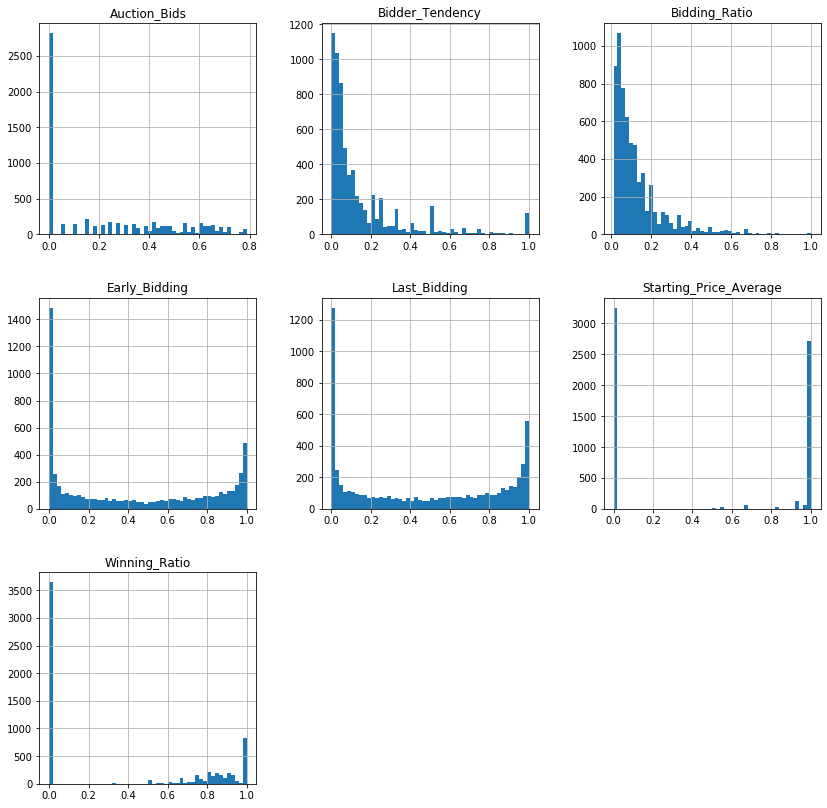

In [110]:
feature_num_names = ['Auction_Bids','Bidder_Tendency','Bidding_Ratio', 'Early_Bidding', 
                        'Last_Bidding', 'Starting_Price_Average', 'Winning_Ratio']
X[feature_num_names].hist(figsize=(14,14), bins=50, grid=True);

Скорее всего, данные были уже отнормированы. Посмотрим на соотношение классов.

In [114]:
y.value_counts(normalize=True)

0    0.893213
1    0.106787
Name: Class, dtype: float64

Обучим случайный лес.

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

In [157]:
rf = RandomForestClassifier(max_depth=8, n_estimators=200, class_weight='balanced')
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
y_preds[:10]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [188]:
def evaluate_results(y_test, y_preds):
    print('Classification results:')
    f1 = f1_score(y_test, y_preds)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_preds)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_preds, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_preds, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_preds)

Classification results:
f1: 93.33%
roc: 98.62%
recall: 98.87%
precision: 88.38%


Сделаем PU learning. Пусть нам известны негативы и часть позитивов.

In [222]:
X = X.copy()
#get the indices of the positives samples
pos_ind = np.where(X.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 323/1289 as positives and unlabeling the rest


In [223]:
X['class_test'] = -1
X.loc[pos_sample,'class_test'] = 1
print('target variable:\n', X.iloc[:,-1].value_counts())

target variable:
 -1    5998
 1     323
Name: class_test, dtype: int64


Класс -1 означает, что этот класс не размечен.

In [224]:
X.head()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,class_test
0,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,-1
1,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,-1
2,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,-1
3,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,-1
4,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,-1


In [225]:
x_data = X.iloc[:,:-2].values # just the X 
y_labeled = X.iloc[:,-1].values # new class (just the P & U)
y_positive = X.iloc[:,-2].values # original class

Применим random negative sampling(бэггинг над решающими деревьями).

In [226]:
X = X.sample(frac=1)
neg_sample = X[X['class_test']==-1][:len(X[X['class_test']==1])]
sample_test = X[X['class_test']==-1][len(X[X['class_test']==1]):]
pos_sample = X[X['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(323, 10) (323, 10)


In [228]:
sample_train

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,class_test
2102,0.080000,0.035714,0.0,0.020899,0.678571,0.993593,0.020891,0.0,7,-1
3599,1.000000,0.049180,0.0,0.756460,0.704918,0.993593,0.756460,0.0,7,-1
3484,0.017241,0.076923,0.0,0.020890,0.000000,0.993593,0.020890,0.0,7,-1
5176,0.038462,0.076923,0.0,0.266860,0.000000,0.000000,0.266860,0.0,3,-1
720,0.009804,0.052632,0.0,0.315428,0.052632,0.993593,0.315428,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...
6246,0.013333,0.055556,0.0,0.899294,0.000000,0.000000,0.899294,0.0,1,1
1318,0.062500,0.037037,0.0,0.855498,0.333333,0.000000,0.855498,0.0,1,1
5915,0.500000,0.023256,0.0,0.401883,0.581395,0.993528,0.401883,0.0,3,-1
3379,0.400000,0.090909,0.0,0.989329,0.181818,0.000000,0.989329,0.0,1,1


In [230]:
model = RandomForestClassifier(max_depth=8, n_estimators=200)

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Random negative sampling можно использовать тогда, когда распределение выборки не отличается от генеральной совокупности. Для 
2-step approach это не проблема, поскольку на втором этапе берётся подвыборка и делается подгонка под распределение той выборки, с которой взяли подвыборку. В целом, думаю, если предположить, что клиентская база- это генеральная совокупность и если стоит 
задача привлекать новых клиентов, то лучше использовать 2-step approach, поскольку распределение в клиентской базе может не
соотвествовать генеральной совокупности(внешняя среда), а этот подход рано или поздно сделает подгонку. Если бизнес-задачи
позволяют делать менее строгую формулировку, то можно использовать random negative sampling и терять в эффективности.